In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import seaborn as sns
import pandas_datareader as web
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense



In [2]:
df = yf.download('NFLX', start='2022-09-22', end='2023-09-26')





[*********************100%%**********************]  1 of 1 completed


In [3]:
df.columns=df.columns.str.lower()

In [4]:
df=df.round(2)

In [5]:
df["Target"]=df["close"].shift(-2).ffill()
df["open_shift"]=np.random.uniform(200,443,size=df.shape[0])
df["high_shift"]=np.random.uniform(300,485,size=df.shape[0])
df["low_shift"]=np.random.uniform(250,470,size=df.shape[0])
df["close_shift"]=np.random.uniform(224,477,size=df.shape[0])
df["volume_shift"]=np.random.uniform(3.298,22128.300,size=df.shape[0])
filt1=df.columns.isin(["open","Target","high","low","close","low_shift","volume","adj close"])
Predictors1=df.columns[~filt1]
X1=df[Predictors1]

In [6]:
null_pct=df.apply(pd.isna).sum()/df.shape[0]

In [7]:
df

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2022-09-22,235.35,240.50,231.66,237.05,237.05,10018000,224.07,434.303151,315.089814,403.723015,404.648022,8768.272812
2022-09-23,235.14,236.45,221.43,226.41,226.41,11207200,224.36,413.980029,442.799668,252.641895,400.935207,17311.273008
2022-09-26,225.60,232.70,223.01,224.07,224.07,8234300,245.20,307.303319,397.225302,364.937386,357.525942,20883.813599
2022-09-27,228.63,230.64,220.72,224.36,224.36,7762200,239.71,214.962443,341.393178,305.125590,237.813617,1346.579386
2022-09-28,229.69,246.65,227.38,245.20,245.20,17579700,235.44,337.055910,465.609774,260.414315,427.585072,1959.654510
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.15,203.568388,421.963664,381.985249,453.675050,4606.768050
2023-09-20,397.05,397.99,386.12,386.30,386.30,3866600,379.81,306.613815,463.484404,329.420656,268.775419,18186.010431
2023-09-21,386.50,395.90,383.42,384.15,384.15,5547900,383.15,359.551856,311.960799,253.824661,443.388127,2346.166859


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_absolute_error
filt=df.columns.isin(["Target","adj close","low","open_shift","close_shift","low_shift","high_shift","volume_shift"])
predictors=df.columns[~filt]
R=LinearRegression()
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
r=Ridge(alpha=1.0)
scaler=StandardScaler()
S=Sequential()
X=df[predictors]
y=df["Target"]


In [9]:
def backtest(data,model,predictors,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["Target"]
        X_test=test[predictors]
        y_test=test["Target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)
    
def forecast_next_days(data, model, predictors, step=5, num_days=5):
    last_train = data.iloc[-step:]
    #last_train_f = last_train.filter(["Target"])
    #last_train1 = scaler.fit_transform(last_train_f)
    next_days = pd.date_range(
        start=last_train.index[-1] + pd.Timedelta(days=1),
        periods=num_days
    )

    G = np.random.uniform(370, 390, size=num_days)
    sample_rows = pd.Series(G)
    model.fit(last_train[predictors],last_train["Target"])
    next_preds = model.predict(last_train[predictors][:num_days])
    #next_preds = model.predict(last_train_f[:num_days])
    #next_preds = scaler.inverse_transform(next_preds)
    next_diff = np.abs(sample_rows.values - next_preds)

    next_preds_df = pd.DataFrame({
        "Actual": sample_rows.values,
        "Predicted": next_preds,
        "Diff": next_diff
    }, index=next_days)

    return next_preds_df,next_preds


In [10]:
Combined = backtest(df, r, predictors)

Combined5,pred=forecast_next_days(df,r,Predictors1)


In [11]:
Combined5

,Actual,Predicted,Diff
2023-09-26,387.172595,384.150286,3.022309
2023-09-27,382.655750,379.811432,2.844318
2023-09-28,382.956786,383.150314,0.193528
2023-09-29,385.341929,383.148204,2.193725
2023-09-30,385.541747,383.149764,2.391983


In [12]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])

C:\Users\nbana\OneDrive\Desktop\test\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


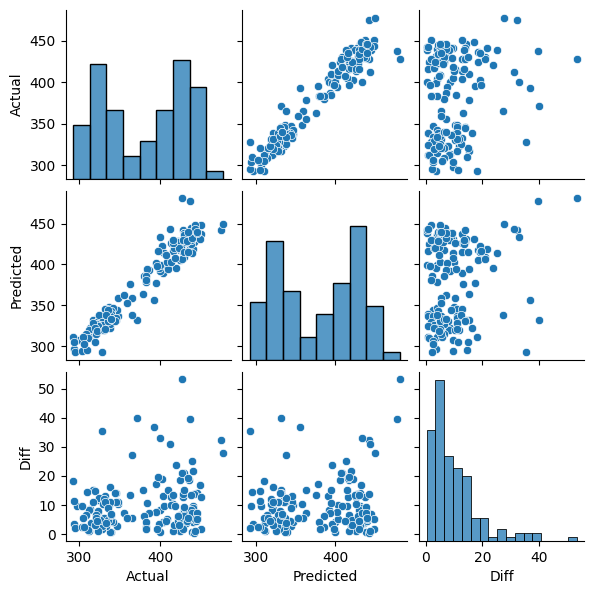

In [13]:
sns.pairplot(Combined, diag_kind='hist', height=2)

In [14]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1378.
Date:                Mon, 25 Sep 2023   Prob (F-statistic):          4.86e-168
Time:                        16:09:58   Log-Likelihood:                -1006.5
No. Observations:                 253   AIC:                             2023.
Df Residuals:                     248   BIC:                             2041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7271      5.509      1.947      0.053      -0.124      21.578
open          -0.0711      0.171     -0.417      0.677      -0.407       0.265
high           0.2034      0.291      0.698      0.486      -0.370       0.777
close          0.8354      0.202      4.133      0.000       0.437       1.234
volume      6.627e-08   1.87e-07      0.355      0.723   -3.01e-07    4.34e-07
==============================================================================
Omnibus:                        6.665   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               10.286
Skew:                           0.081   Prob(JB):                      0.00584
Kurtosis:                       3.974   Cond. No.                     6.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
vif=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x.values,i)for i in range(x.shape[1])],"features":x.columns}))

In [16]:
x1=sm.add_constant(X1)
result=sm.OLS(y,x1).fit()
result.summary()
vif1=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x1.values,i)for i in range(x1.shape[1])],"features":x1.columns}))

In [17]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])
vif1

,VIF,features
0,107.412790,const
1,1.026477,open_shift
2,1.028879,high_shift
3,1.008280,close_shift
4,1.020087,volume_shift


In [18]:
from datetime import datetime
current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
CombinedX = pd.concat([Combined, Combined5])
U=CombinedX.loc[:f"{DATE}"]

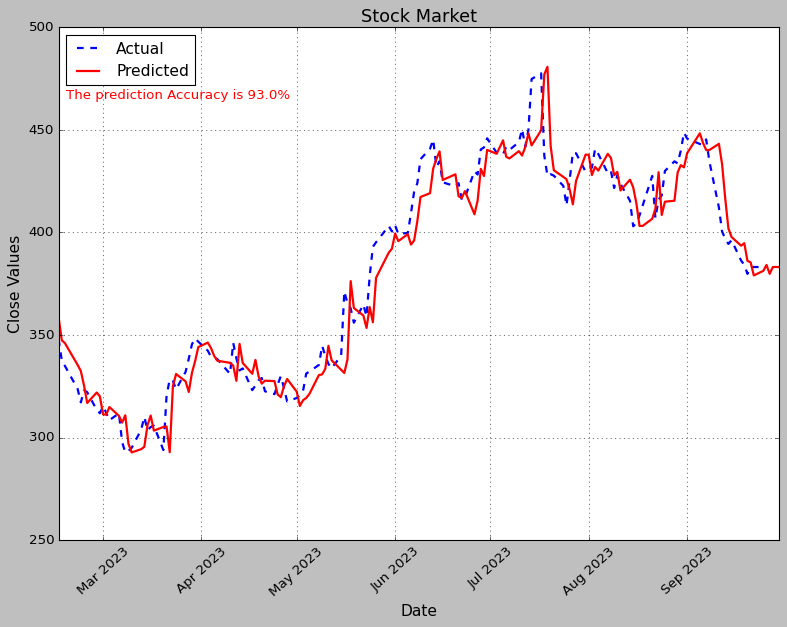

In [19]:
import matplotlib.pyplot as plt


plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(U.index,U["Actual"],"b--",label="Actual",linewidth=2)
plt.plot(CombinedX.index,CombinedX["Predicted"],"r-",label="Predicted",linewidth=2)
plt.legend(loc="upper left",fontsize=14)
plt.xticks(rotation=42)
# Annotating a point
plt.annotate(f"The prediction Accuracy is {round(acc,2)*100}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.01, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)
plt.grid()
plt.savefig("Ps.png",dpi=300,bbox_inches="tight")
plt.tight_layout()


In [20]:
acc

0.9321738656314471

In [21]:
df.tail(90)

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2023-05-17,331.76,341.38,329.62,339.96,339.96,3958800,365.36,242.196913,407.596554,250.063914,345.984587,8865.318388
2023-05-18,347.25,375.87,346.37,371.29,371.29,20925200,363.01,264.173400,309.669514,317.087456,348.216794,13018.981939
2023-05-19,369.86,369.99,363.81,365.36,365.36,7850900,355.99,215.787949,424.821042,406.813991,388.379956,16328.209927
2023-05-22,365.36,372.01,362.50,363.01,363.01,5406400,364.85,385.095771,330.290538,289.146084,249.154863,7908.200558
2023-05-23,360.24,364.17,354.31,355.99,355.99,6866100,359.00,382.275651,438.414473,377.869078,352.486811,14811.397635
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.15,203.568388,421.963664,381.985249,453.675050,4606.768050
2023-09-20,397.05,397.99,386.12,386.30,386.30,3866600,379.81,306.613815,463.484404,329.420656,268.775419,18186.010431
2023-09-21,386.50,395.90,383.42,384.15,384.15,5547900,383.15,359.551856,311.960799,253.824661,443.388127,2346.166859


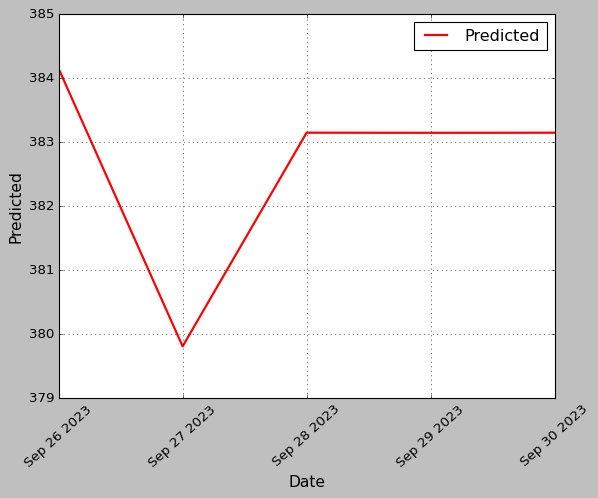

In [22]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.lineplot(Combined5,x=Combined5.index,y="Predicted",linewidth=2,color="r",label="Predicted")
plt.xticks(Combined5.index,rotation=42)
plt.xlabel("Date",fontsize=14)
plt.ylabel("Predicted",fontsize=14)

plt.grid()


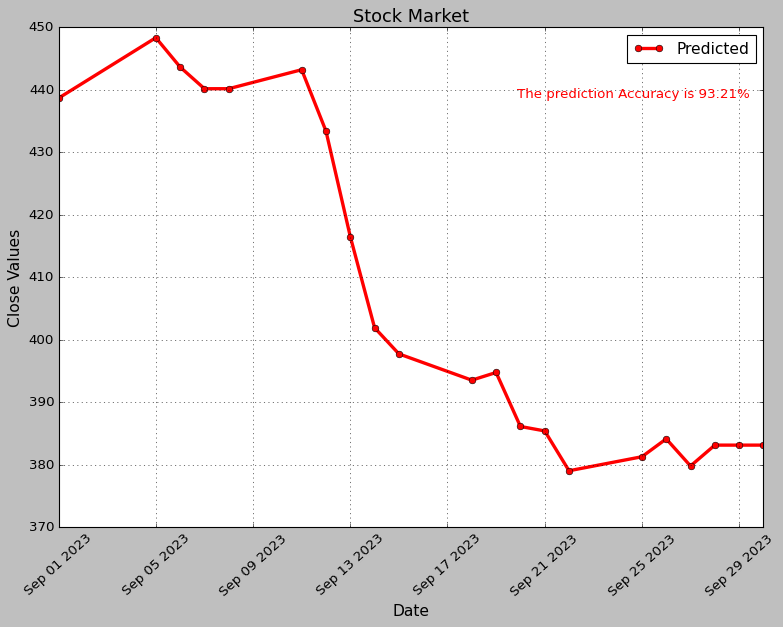

In [23]:
plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
#plt.plot(CombinedX.loc["2023-09-01":f"{DATE}"].index,CombinedX.loc["2023-09-01":f"{DATE}","Actual"],"b-o",label="Actual",linewidth=3)
plt.plot(CombinedX.loc["2023-09-01":].index,CombinedX.loc["2023-09-01":,"Predicted"],"r-o",label="Predicted",linewidth=3)
plt.legend(loc="upper right",fontsize=14)
plt.xticks(rotation=42,)
Acc=r2_score(CombinedX["Actual"],CombinedX["Predicted"])
# Annotating a point
plt.grid()
plt.annotate(f"The prediction Accuracy is {round(Acc*100,2)}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.65, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)


plt.tight_layout()


In [26]:
CombinedX.tail(10)

,Actual,Predicted,Diff
2023-09-19,384.150000,394.770936,10.620936
2023-09-20,379.810000,386.132457,6.322457
2023-09-21,383.150000,385.421875,2.271875
2023-09-22,383.150000,379.046304,4.103696
2023-09-25,383.150000,381.289946,1.860054
2023-09-26,387.172595,384.150286,3.022309
2023-09-27,382.655750,379.811432,2.844318
2023-09-28,382.956786,383.150314,0.193528
2023-09-29,385.341929,383.148204,2.193725
2023-09-30,385.541747,383.149764,2.391983
